In [ ]:
!pip install -q transformers datasets librosa

In [ ]:
from transformers import AutoModel, AutoTokenizer
from datasets import load_dataset

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import os
import re
import random
import itertools
from collections import defaultdict
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt

In [ ]:
def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42)

#### 🌀 Загружаем данные (предварительно загрузите их с диска в Google Colab)

[Ссылка на данные](https://disk.yandex.ru/d/awG8jCY01BGcAQ)

In [ ]:
labels = ["anger", "disgust", "fear", "joy", "sadness", "surprise", "neutral"]

data = load_dataset("csv", data_files={"train": "/content/big_train.csv", "validation": "/content/valid.csv"})
data

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'text', 'anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'neutral'],
        num_rows: 65584
    })
    validation: Dataset({
        features: ['Unnamed: 0', 'text', 'anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'neutral'],
        num_rows: 5426
    })
})

#### 🔎 Выведем уникальные символы в сплитах

In [ ]:
def get_alphabet(data_split):
    alphabet = set()
    for sample in data_split:
        uniq_chars = set(sample["text"])
        alphabet.update(uniq_chars)
    return alphabet

print("Train unique symbols: ", get_alphabet(data["train"]))
print("Valid unique symbols: ", get_alphabet(data["validation"]))

Train unique symbols:  {'э', '🤤', ']', 'Й', 'Ш', 'б', 'S', '👍', '😩', '💋', '⠋', '🙃', 'ʖ', '"', '허', '💡', 'D', '🍻', '♪', '개', '💭', '[', '😬', '5', '😤', '{', '♥', '💁', '\\', 'K', '👨', '🇺', 'ñ', 'Ю', '👎', 'U', '🚀', 'I', '🥰', '🍰', 'Ё', '😍', 'z', '🛡', 'Ɲ', 'Щ', '😘', '💜', '⚔', '🐇', '👅', '⚡', 'ň', '}', 'к', 't', '3', '🙊', '⡇', '🙏', '🎖', '⡾', 'q', '⠟', '👐', '✊', '国', '🇸', '💰', '🤭', '?', '😪', '😃', '💄', ';', 'Л', '🌈', 'З', '？', '🏻', 'Д', ')', '⢰', 'F', '🇫', '&', 'Н', '…', '😅', '😓', '🏼', 'д', '✨', '👋', '⢣', '⠸', '⠀', '💨', '⠶', '･', '🤪', '🏽', 'ʌ', '🔥', '’', 'v', '😢', '🤓', '💖', '.', '9', 'O', '⠻', '⠞', '😝', '💲', 'г', 'ˈ', '⣦', '⡟', 'x', 'R', '👉', '😗', '♀', 'T', '💙', '✌', '⣶', '⢤', '😟', 'c', '😮', '⢿', '⠳', 'К', '😳', '⠊', '⣄', '⡷', '💯', '🙄', '🤷', '☕', '«', '🤚', '⠈', 'Y', '😇', 'f', '🤢', '|', '什', '⡜', 'О', '➡', 'ı', '🍩', 'т', '0', 'р', '-', '☁', '雅', 'А', 'N', 'Б', '💓', '玛', '😸', 'p', '在', '🏈', '🧡', '🇷', 'e', 'g', '⣠', '🤠', 'Е', 'И', '😱', 'P', '🚓', '⠹', '🍁', '🤩', '😫', '👏', '⠃', '😻', '😑', '🤮', 'r', '中', 

#### 📊 Построим гистограммы распределения

In [ ]:
def plot_histogram(data_split):
    class_counts = {
        'anger': 0,
        'disgust': 0,
        'fear': 0,
        'joy': 0,
        'sadness': 0,
        'surprise': 0,
        'neutral': 0
    }

    for sample in data_split:
        for emotion in labels:
            class_counts[emotion] += sample[emotion]

    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(10, 6))
    plt.bar(classes, counts)
    plt.xlabel('Классы эмоций')
    plt.ylabel('Количество')
    plt.title('Распределение по классам эмоций')
    plt.xticks(rotation=45)

    plt.show()

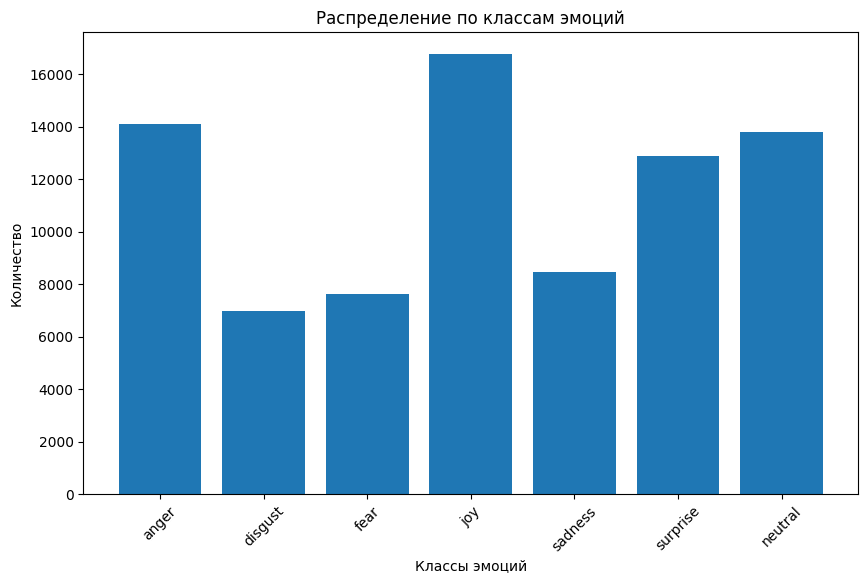

In [ ]:
plot_histogram(data["train"])

In [ ]:
def plot_combined_emotions(data_split):
    emotion_pairs = defaultdict(int)

    for entry in data_split:
        emotions = {key: value for key, value in entry.items() if key in labels}
        active_emotions = [emotion for emotion, value in emotions.items() if value > 0]

        for pair in itertools.combinations(sorted(active_emotions), 2):
            emotion_pairs[pair] += 1

    sorted_pairs = sorted(emotion_pairs.items(), key=lambda x: x[1], reverse=True)
    pairs = [f"{pair[0]} & {pair[1]}" for pair, _ in sorted_pairs]
    counts = [count for _, count in sorted_pairs]

    plt.figure(figsize=(12, 6))
    plt.bar(pairs, counts)
    plt.xlabel('Пары эмоций')
    plt.ylabel('Количество')
    plt.title('Совместное появление эмоций')
    plt.xticks(rotation=45)

    plt.show()

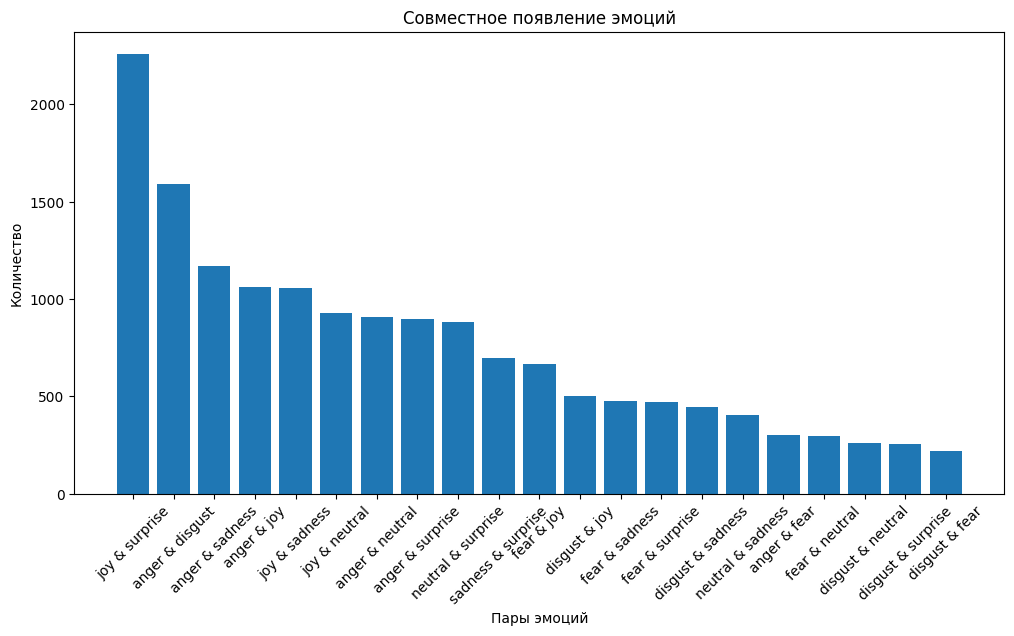

In [ ]:
plot_combined_emotions(data["train"])

#### 🧹 Приведем тексты к нижнему регистру и удалим лишние знаки

In [ ]:
def cleaner(example):
    example["text"] = example["text"].lower()
    example["text"] = re.sub(r"[^a-zа-я\d]", " ", example["text"])
    example["text"] = re.sub(r"\s+", " ", example["text"])
    example["text"] = example["text"].strip()
    return example

In [ ]:
data = data.map(cleaner)

In [ ]:
data["train"][3]

{'Unnamed: 0': 3,
 'text': 'имя из за этого я чувствую себя старым',
 'anger': 0,
 'disgust': 0,
 'fear': 0,
 'joy': 0,
 'sadness': 0,
 'surprise': 0,
 'neutral': 1}

#### 🏋️ Подготовим модель

In [ ]:
class Model(torch.nn.Module):
    def __init__(self, pretrained_model, hidden_dim, num_classes):
        super().__init__()
        self.bert = AutoModel.from_pretrained(pretrained_model)
        # добавила доп слои
        self.linear_relu_stack = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, 512*2),
            torch.nn.Dropout(0.1),
            torch.nn.ReLU(),
            torch.nn.Linear(512*2, 512),
            torch.nn.Dropout(0.1),
            torch.nn.ReLU(),
        )
        self.final = torch.nn.Linear(512, num_classes)

        # дообучаем bert
        self.bert.requires_grad_(False)
        for param in self.bert.encoder.parameters():
            param.requires_grad = True

    def forward(self, ids, mask, token_type_ids):
        _, x = self.bert(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
        x = self.linear_relu_stack(x)
        out = self.final(x)
        return out

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model(pretrained_model="ai-forever/ruBert-base", hidden_dim=768, num_classes=len(labels))
model = model.to(device)

OutOfMemoryError: CUDA out of memory. Tried to allocate 352.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 65.06 MiB is free. Process 8464 has 14.68 GiB memory in use. Of the allocated memory 14.33 GiB is allocated by PyTorch, and 228.67 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

#### 📒 Подготовим данные для обучения

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("ai-forever/ruBert-base")
max_len = 64

data = data.map(lambda examples: tokenizer(examples["text"],
                                           truncation=True,
                                           add_special_tokens=True,
                                           max_length=max_len,
                                           padding="max_length"), batched=True)

In [ ]:
def one_hot_to_list(example):
    emotions = []
    for emotion in labels:
        emotions.append(example[emotion])
    example["one_hot_labels"] = emotions

    return example

data = data.map(one_hot_to_list)
data["train"][9]["one_hot_labels"]

#### 🔗 Dataset & DataLoader

In [ ]:
class EmotionDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        return {
            'input_ids': torch.tensor(self.dataset[index]["input_ids"], dtype=torch.long),
            'attention_mask': torch.tensor(self.dataset[index]["attention_mask"], dtype=torch.long),
            'token_type_ids': torch.tensor(self.dataset[index]["token_type_ids"], dtype=torch.long),
            'labels': torch.tensor(self.dataset[index]["one_hot_labels"], dtype=torch.float)
        }

In [ ]:
train_dataset = EmotionDataset(data["train"])
valid_dataset = EmotionDataset(data["validation"])

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=64, shuffle=False) # поменяла batch_size

#### 🚀 Инициализируем функцию ошибки и оптимизатор

In [ ]:
criterion = torch.nn.BCEWithLogitsLoss() #CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001, weight_decay=0.0) # поменяла lr и weight_decay

#### 🥷 Код для обучения и валидации

In [ ]:
def train(model, criterion, optimizer, dataloader):
    train_loss = 0.0
    model.train()
    for idx, data in enumerate(dataloader):
        ids = data["input_ids"].to(device, dtype=torch.long)
        mask = data["attention_mask"].to(device, dtype=torch.long)
        token_type_ids = data["token_type_ids"].to(device, dtype=torch.long)
        labels = data["labels"].to(device, dtype=torch.float)

        outputs = model(ids, mask, token_type_ids)
        loss = criterion(outputs, labels)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    print(f'Train loss: {train_loss / len(dataloader)}')

    return model

In [ ]:
def validation(model, criterion, dataloader):
    val_loss = 0.0
    model.eval()
    val_targets, val_outputs = [], []
    with torch.no_grad():
        for idx, data in enumerate(dataloader):
            ids = data["input_ids"].to(device, dtype=torch.long)
            mask = data["attention_mask"].to(device, dtype=torch.long)
            token_type_ids = data["token_type_ids"].to(device, dtype=torch.long)
            labels = data["labels"].to(device, dtype=torch.float)

            outputs = model(ids, mask, token_type_ids)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            val_targets.extend(labels.cpu().detach().numpy().tolist())
            val_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

    print(f'Valid loss: {val_loss / len(dataloader)}')

    return val_outputs, val_targets

#### 🏃‍♂️‍➡️ Запускаем обучение

In [ ]:
epochs = 4

for epoch in range(epochs):
    print(f"Epoch: {epoch}")
    model = train(model, criterion, optimizer, train_dataloader)
    val_outputs, val_targets = validation(model, criterion, valid_dataloader)

In [ ]:
outputs, targets = validation(model, criterion, valid_dataloader)
outputs = np.array(outputs) >= 0.28
print(metrics.classification_report(targets, outputs, target_names=labels))

In [ ]:
outputs, targets = validation(model, criterion, valid_dataloader)
outputs = np.array(outputs) >= 0.27
print(metrics.classification_report(targets, outputs, target_names=labels))

#### ✏️ Получаем результаты на тесте

In [ ]:
test = load_dataset("csv", data_files={"test": "/content/test_without_answers.csv"})

In [ ]:
test = test.map(lambda examples: tokenizer(examples["text"],
                                           truncation=True,
                                           add_special_tokens=True,
                                           max_length=max_len,
                                           padding="max_length"), batched=True)

test = test.map(one_hot_to_list)

In [ ]:
test_dataset = EmotionDataset(test["test"])
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
outputs, _ = validation(model, criterion, test_dataloader)
outputs = np.array(outputs) >= 0.5

#### 🧑‍🍳 Готовим сабмит

In [ ]:
import pandas as pd

df = pd.read_csv("/content/test_without_answers.csv")

Изначально все метки классов инициализированы нулями, нужно их заполнить результатами модели.

In [ ]:
df.head()

In [ ]:
df[labels] = outputs.astype(int)

In [ ]:
df.head()

In [ ]:
df.to_csv("/content/submission.csv", index=False)